# MNIST - Handwriting Recognition

In [2]:
from com.yahoo.ml.caffe.DisplayUtils import *
from com.yahoo.ml.caffe.CaffeOnSpark import *
from com.yahoo.ml.caffe.Config import *
from com.yahoo.ml.caffe.DataSource import *

## Training Data

In [1]:
df = sqlCtx.read.parquet('/Users/afeng/dev/ml/CaffeOnSpark/data/mnist_test_dataframe')

In [3]:
show_df(df,5)

Index,Label,Image
00000000,7,
00000001,2,
00000002,1,
00000003,0,
00000004,4,


# Training

In [4]:
cos=CaffeOnSpark(sc)

In [5]:
args={}
args['conf']='/Users/afeng/dev/ml/CaffeOnSpark/data/lenet_dataframe_solver.prototxt'
args['model']='file:///tmp/lenet.model'
args['devices']='1'
args['clusterSize']='1'
cfg=Config(sc,args)

In [6]:
dl_train_source = DataSource(sc).getSource(cfg,True)
dl_validation_source = DataSource(sc).getSource(cfg,False)

In [7]:
cos.train(dl_train_source)

In [8]:
validation_result_df = cos.trainWithValidation(dl_train_source, dl_validation_source)

In [31]:
validation_result_df.count()

199

In [39]:
validation_result_df.show(20)

+------------+-------------+
|    accuracy|         loss|
+------------+-------------+
| [0.8093763]| [0.55813646]|
| [0.8937512]| [0.33698168]|
| [0.9031262]| [0.32773605]|
| [0.8734357]| [0.38087258]|
|[0.95156115]|  [0.1565354]|
| [0.9531276]| [0.14995836]|
| [0.9281297]| [0.20006998]|
| [0.9593701]| [0.15223119]|
|[0.98437566]|[0.049042027]|
|[0.97343445]| [0.07589754]|
| [0.9812499]| [0.06388679]|
| [0.9874952]| [0.03984064]|
| [0.9828122]|[0.051861253]|
| [0.9953066]|[0.022694288]|
| [0.9828057]| [0.04345445]|
| [0.9687469]| [0.10477835]|
| [0.9734369]|[0.099641055]|
|[0.96405977]| [0.11023067]|
| [0.9718719]| [0.09426022]|
| [0.9718768]| [0.08968722]|
+------------+-------------+
only showing top 20 rows



In [12]:
%matplotlib notebook
from matplotlib import pyplot as plt

<IPython.core.display.Javascript object>


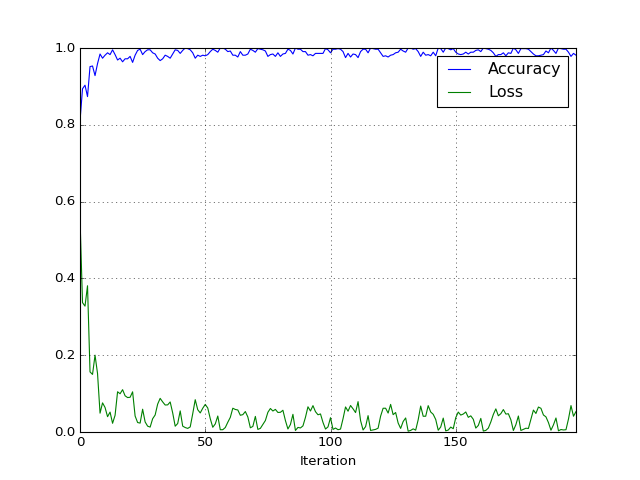

In [14]:
validation_panda_df = validation_result_df.toPandas()
validation_panda_df.accuracy.apply(lambda x: x[0]).plot()
validation_panda_df.loss.apply(lambda x: x[0]).plot()
plt.grid()
plt.xlabel('Iteration')
plt.legend(('Accuracy', 'Loss'))

# Test

In [15]:
dl_test_source = DataSource(sc).getSource(cfg,False)

In [16]:
test_result=cos.test(dl_test_source)

In [17]:
test_result

{u'accuracy': [0.9907852564102564], u'loss': [0.029657003584833756]}

# Feature Extraction

In [18]:
args['features']='accuracy,ip1,ip2'
args['label']='label'
cfg=Config(sc,args)

In [19]:
dl_feature_source = DataSource(sc).getSource(cfg,False)

In [20]:
f=cos.features(dl_feature_source)

In [21]:
f.show(5)

+--------+--------+--------------------+--------------------+-----+
|SampleID|accuracy|                 ip1|                 ip2|label|
+--------+--------+--------------------+--------------------+-----+
|00000000|   [1.0]|[2.6088552, 1.172...|[-1.4996569, 1.01...|[7.0]|
|00000001|   [1.0]|[-0.0, -0.0, -0.0...|[3.1911962, 6.265...|[2.0]|
|00000002|   [1.0]|[-0.0, 0.38665527...|[-0.6574185, 12.7...|[1.0]|
|00000003|   [1.0]|[2.7852693, 3.924...|[14.25194, -3.340...|[0.0]|
|00000004|   [1.0]|[1.6561224, 0.323...|[-3.2196107, -2.9...|[4.0]|
+--------+--------+--------------------+--------------------+-----+
only showing top 5 rows



In [22]:
def maxScoreAndIndex(array_of_scores): 
    return max(enumerate(array_of_scores), key=lambda x: x[1])
g = sqlContext.createDataFrame(f.map(lambda row: (
            row.SampleID,
            row.accuracy[0],
            row.ip2,
            maxScoreAndIndex(row.ip2)[1],
            maxScoreAndIndex(row.ip2)[0],
            int(row.label[0]))), 
            ["SampleID", "Accuracy", "Scores", "MaxScore", "Prediction", "Label"])
g.toPandas()[:5]

,SampleID,Accuracy,Scores,MaxScore,Prediction,Label
0,00000000,1.0,"[-1.49965691566, 1.01030933857, 1.5530872345, ...",18.340185,7,7
1,00000001,1.0,"[3.19119620323, 6.26545763016, 22.5383586884, ...",22.538359,2,2
2,00000002,1.0,"[-0.657418489456, 12.7434282303, 0.49634182453...",12.743428,1,1
3,00000003,1.0,"[14.2519397736, -3.34089517593, 0.631735026836...",14.251940,0,0
4,00000004,1.0,"[-3.21961069107, -2.96179223061, -3.2213973999...",15.806371,4,4


###  Logistic Regression using MLlib

In [23]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import LogisticRegressionWithLBFGS

In [24]:
data = f.map(lambda row: LabeledPoint(row.label[0], Vectors.dense(row.ip1)))

In [25]:
lr = LogisticRegressionWithLBFGS.train(data, numClasses=10, iterations=10)

In [26]:
predictions = lr.predict(data.map(lambda pt : pt.features))

In [27]:
predictions.take(5)

[7, 2, 1, 0, 4]